## Inverse noise covariance operators for `litebird_sim`

This notebook shows how to create the inverse noise covariance operators for the BrahMap's interface to `litebird_sim` (LBS). The operators discussed here are essentially the block-diagonal operators where each block corresponds to one observation instance of a detector. That means, it assumes that there is no noise correlation between different observation instance and different detectors.

Similar to other inverse covariance operators, all the operators discussed here provide a `diag` attribute, which retrieves the diagonal elements of the operator, and a `get_inverse()` method that returns the inverse of the operator. For LBS, while we provide the interface only for inverse covariances, it is possible to obtain covariance operator using `get_inverse()` method.

All LBS inverse covariance operators are defined locally. This means that, for consistency, the user must ensure that the inverse noise covariance defined on each MPI process corresponds to the TOD available locally on that process. Additionally, the user must ensure that the order of the blocks in the operator corresponds to the order of the TODs of different observations and detectors - as it is processed with `LBSimProcessTimeSamples`.

In addition to the operators discussed here, it is possible to create block-diagonal inverse covariance operators with different types of blocks. One can use `brahmap.base.BaseBlockDiagInvNoiseCovLinearOperator()` class for this purpose ensuring that the conditions discussed above hold true. See [examples for the block-diagonal noise covariance](./block_diagonal_noise_covariances.ipynb) for more details.

<div class="alert alert-block alert-warning">

**NOTE**  
The linear operators defined in BrahMap can be visualized using the `brahmap.utilities.plot_LinearOperator()` function. This function requires `matplotlib` to be installed. However, it must be used very carefully, as it allocates a large array in memory - matching the dimensions of the linear operator - which can quickly crash your system. In these examples, we use this function because our operators are very small.

</div>


In [1]:
### If you are using Google Colab, uncomment the following line and execute this cell to install the required packages

# %pip install matplotlib healpy litebird_sim git+https://github.com/anand-avinash/BrahMap.git

In [2]:
import tempfile
import numpy as np
import litebird_sim as lbs
import brahmap
from brahmap.utilities import plot_LinearOperator

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [3]:
### Creating a basic LBS simulation

tmp_dir = tempfile.TemporaryDirectory().name

sim = lbs.Simulation(
    base_path=tmp_dir,
    start_time=45,
    duration_s=71,
    random_seed=154,
)

detector_list = [
    lbs.DetectorInfo(name="det1", sampling_rate_hz=1, net_ukrts=1.5),
    lbs.DetectorInfo(name="det2", sampling_rate_hz=1, net_ukrts=2.9),
    lbs.DetectorInfo(name="det3", sampling_rate_hz=1, net_ukrts=3.6),
    lbs.DetectorInfo(name="det4", sampling_rate_hz=1, net_ukrts=4.2),
]

sim.create_observations(
    detectors=detector_list,
    num_of_obs_per_detector=3,
    n_blocks_det=1,
    n_blocks_time=1,
    split_list_over_processes=False,
)

### Inverse noise covariance with diagonal covariance blocks

The inverse noise covariance operator with diagonal covariance blocks can be defined using `LBSim_InvNoiseCovLO_UnCorr()` class with the following arguments:

- `obs`  
    An instance or a list of instances of the `Observation` class
- `noise_variance`  
    When `noise_variance` is `None` (default), it uses the noise properties stored in `obs` to create the inverse operators. Otherwise, it accepts a dictionary that maps the detector name to their noise variance. If a detector name is missing in the dictionary, its variance is assigned as 1 by default.
- `dtype`  
    The data-type of the linear operator

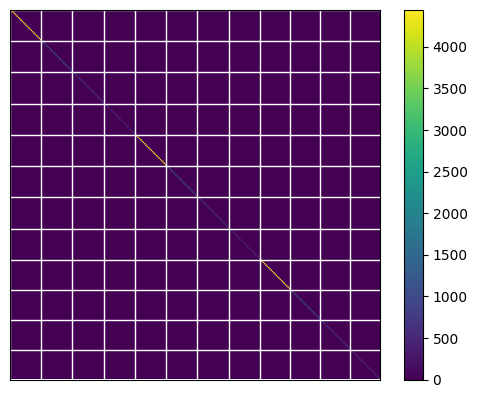

In [4]:
### Example 1: With `noise_Variance = None`

# Creating the inverse noise covariance operator
inv_diag_cov1 = brahmap.LBSim_InvNoiseCovLO_UnCorr(
    obs=sim.observations,
    noise_variance=None,
    dtype=np.float32,
)


# Visualizing the operator
plot_LinearOperator(inv_diag_cov1)

Note that the number of blocks in the linear operator is 12, that is same as the number of observations per detector times number of detectors.

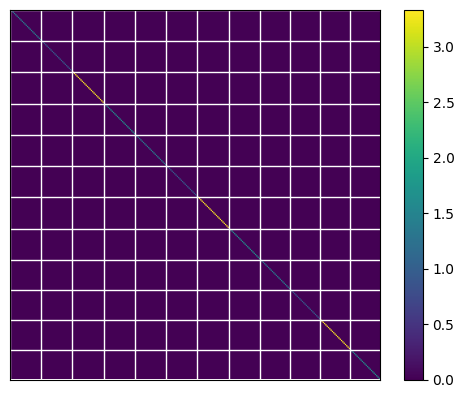

In [5]:
### Example 2: `noise_variance` is specified explicitly

# Creating the noise variance dictionary
noise_variance_dict = {
    "det1": 0.7,
    # "det2", # the operator should set it to 1.0 by default
    "det3": 0.3,
    "det4": 0.6,
}


# Creating the inverse noise covariance operator
inv_diag_cov2 = brahmap.LBSim_InvNoiseCovLO_UnCorr(
    obs=sim.observations,
    noise_variance=noise_variance_dict,
    dtype=np.float32,
)


# Visualizing the operator
plot_LinearOperator(inv_diag_cov2)

### Inverse noise covariance with circulant covariance blocks

The inverse noise covariance operator with circulant covariance blocks can be defined using `LBSim_InvNoiseCovLO_Circulant` class with the following arguments:

- `obs`  
    An instance or a list of the `Observation` class
- `input`  
    A dictionary or a 1-d numpy array containing the noise properties of the detectors in terms of noise covariance or power spectrum. When it is a dictionary, it should map the name of the detector to their noise properties. When the argument is a 1-d numpy array, it is considered as the noise property that is common to all the detectors.
- `input_type`  
    The name of the noise property. If `input` argument contains the noise covariances, `input_type` must be `"covariance"`. Likewise, if the `input` argument contains the power spectrum arrays, the `input_type` must be `power_spectrum`.
- `dtype`  
    The data-type of the linear operator

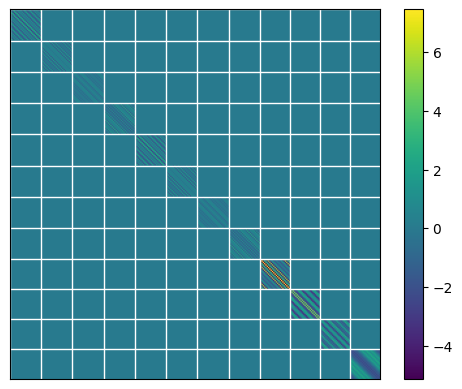

In [6]:
### Example 1: `input` argument is a dictionary

# Creating a dictionary of circulant power spectrum
ps_dict_circ = {}

rng_circ = np.random.default_rng(seed=4551)
for detector in detector_list:
    cov_circ = rng_circ.random(size=sim.observations[0].n_samples)
    ps_circ = np.fft.fft(cov_circ).real

    cov_circ = np.fft.ifft(ps_circ).real
    ps_circ = np.fft.fft(cov_circ).real

    ps_dict_circ[detector.name] = ps_circ


# Creating the inverse noise covariance operator
inv_circ_cov1 = brahmap.LBSim_InvNoiseCovLO_Circulant(
    obs=sim.observations,
    input=ps_dict_circ,
    input_type="power_spectrum",
    dtype=np.float32,
)


# Visualizing the operator
plot_LinearOperator(inv_circ_cov1)

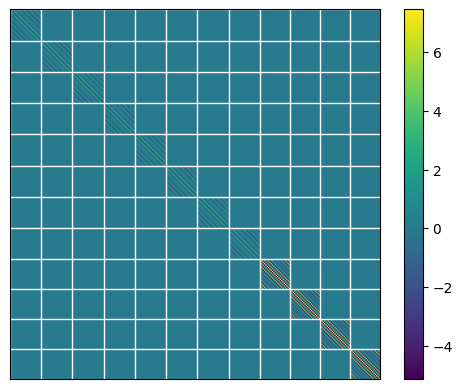

In [7]:
### Example 2: `input` argument is a 1-d numpy array

# Creating a circulant power spectrum array
ps_circ2 = ps_dict_circ["det1"]

# Creating the inverse noise covariance operator
inv_circ_cov2 = brahmap.LBSim_InvNoiseCovLO_Circulant(
    obs=sim.observations,
    input=ps_circ2,
    input_type="power_spectrum",
    dtype=np.float32,
)


# Visualizing the operator
plot_LinearOperator(inv_circ_cov2)

In the two examples above, it can be seen that the last four blocks have considerably different inverse covariance. Since the shape of these four blocks is different than the shape of previous eight blocks, the input power spectrum has been reshaped/re-computed, resulting in a different inverse covariance. The shape of the operators can be verified as given below:

In [8]:
print("size of the rows of the blocks: ", inv_circ_cov1.col_size)
print("size of the columns of the blocks: ", inv_circ_cov1.col_size)

size of the rows of the blocks:  [24 24 24 24 24 24 24 24 23 23 23 23]
size of the columns of the blocks:  [24 24 24 24 24 24 24 24 23 23 23 23]


In [9]:
### Length of the different observations for different detectors

obs_size = []
for obs in sim.observations:
    for detector in obs.name:
        obs_size.append(obs.n_samples)

print("size of the different observations for different detectors:\n ", obs_size)

size of the different observations for different detectors:
  [24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23]


### Inverse noise covariance with Toeplitz covariance blocks

The inverse noise covariance operator with Toeplitz covariance blocks can be defined using `LBSim_InvNoiseCovLO_Toeplitz` class with the following arguments:

- `obs`  
    An instance or a list of the `Observation` class
- `input`  
    A dictionary or a 1-d numpy array containing the noise properties of the detectors in terms of noise covariance or power spectrum. When it is a dictionary, it should map the name of the detector to their noise properties. When the argument is a 1-d numpy array, it is considered as the noise property that is common to all the detectors.
- `input_type`  
    The name of the noise property. If `input` argument contains the noise covariances, `input_type` must be `"covariance"`. Likewise, if the `input` argument contains the power spectrum arrays, the `input_type` must be `power_spectrum`.
- `operator`  
    The operator class to be used for individual inverse Toeplitz operators. It is `InvNoiseCovLO_Toeplitz01` by default.
- `dtype`  
    The data-type of the linear operator

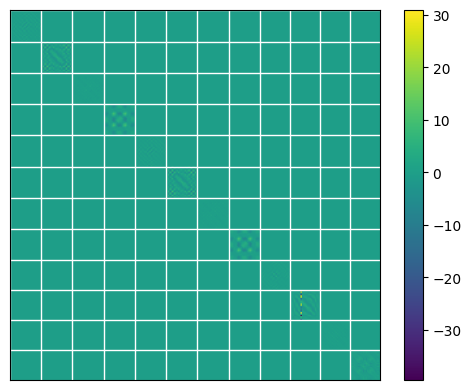

In [10]:
### Example 1: `input` argument is a dictionary

# Creating a dictionary of power spectrum
ps_dict_toep = {}

rng_toep = np.random.default_rng(seed=4551)
for detector in detector_list:
    cov_toep = rng_toep.random(size=sim.observations[0].n_samples)
    extended_cov_toep = np.concatenate([cov_toep, cov_toep[1:-1][::-1]])
    ps_toep = np.fft.fft(extended_cov_toep).real

    ps_dict_toep[detector.name] = ps_toep


# Creating the inverse noise covariance operator
inv_toep_cov1 = brahmap.LBSim_InvNoiseCovLO_Toeplitz(
    obs=sim.observations,
    input=ps_dict_toep,
    input_type="power_spectrum",
    dtype=np.float32,
)


# Visualizing the operator
plot_LinearOperator(inv_toep_cov1)

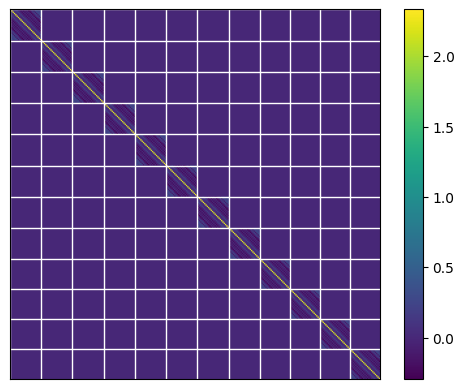

In [11]:
### Example 2: `input` argument is a 1-d numpy array

# Creating the inverse noise covariance operator

# In this example, since the individual blocks of `LBSim_InvNoiseCovLO_Toeplitz`
# are the instance of `InvNoiseCovLO_Toeplitz01` which is based on PCG, it is also
# possible to provide here the preconditioner operator and related arguments as
# keyword arguments to control the behavior of PCG.
inv_toep_cov2 = brahmap.LBSim_InvNoiseCovLO_Toeplitz(
    obs=sim.observations,
    input=rng_toep.random(size=sim.observations[0].n_samples * 2 - 1),
    input_type="power_spectrum",
    operator=brahmap.InvNoiseCovLO_Toeplitz01,
    dtype=np.float32,
    extra_kwargs={
        "precond_op": "KK2",
        "precond_maxiter": 40,
    },
)


# Visualizing the operator
plot_LinearOperator(inv_toep_cov2)

### Inverse noise covariance with different types of covariance blocks for different observations and detectors

In this example, we demonstrate creating the inverse noise covariance operator with different types of covariance block for each observation and detector. To do this, we must define each block operator individually and pass them together as a list to the base class for block-diagonal noise operator. In this particular example, we are using inverse diagonal covariance for each block, but an user can follow the same to use different covariance types.

In [12]:
rng = np.random.default_rng(seed=3434)

In [13]:
### Creating a list of inverse diagonal noise covariance operators

list_ops = []

for obs in sim.observations:
    for det_idx in range(obs.n_detectors):
        inv_op = brahmap.InvNoiseCovLO_Diagonal(
            size=obs.n_samples,
            input=rng.random(1)[0],  # random variance for each operator
            input_type="covariance",
            dtype=np.float32,
        )
        list_ops.append(inv_op)

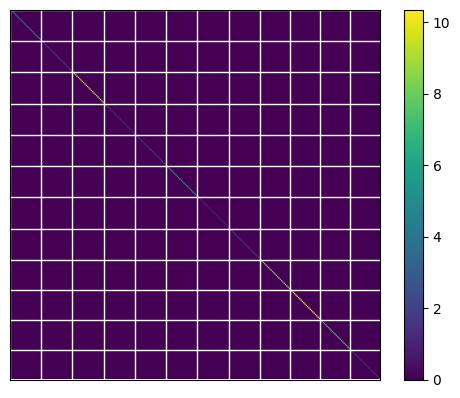

In [14]:
### Creating the block-diagonal inverse noise covariance operator

# As we have already prepared the list individual block operators, we just need to
# pass it to the base class of block-diagonal inverse noise covariance
# operator

inv_blkdiag = brahmap.base.BaseBlockDiagInvNoiseCovLinearOperator(
    block_list=list_ops,
)

### Visualizing the operator
plot_LinearOperator(inv_blkdiag)